## CDS Prevalance

In [3]:
# ── Cell 1: Install & import dependencies ─────────────────────────────────────
!pip install nltk

import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
# ── Cell 2: Set up NLP tools ─────────────────────────────────────────────────
stopwords_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [8]:
# ──  Emoji Pattern ────────────────────────────────────────────────
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\u2600-\u26FF\u2700-\u27BF"  # misc symbols
"]+", flags=re.UNICODE)

In [9]:
# ── Cell 3: Define pre-cleaning function ────────────────────────────────────
def preprocess_text(text):
    """
    1. Lowercase & strip
    2. Remove emojis, URLs, mentions, hashtags
    3. Strip punctuation
    4. Tokenize, remove stopwords
    5. Lemmatize
    """
    text = str(text).lower().strip()
    text = emoji_pattern.sub('', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)        # URLs
    text = re.sub(r'@\w+|#\w+', '', text)               # mentions/hashtags
    text = re.sub(r'[^\w\s]', '', text)                 # punctuation
    tokens = text.split()
    tokens = [tok for tok in tokens if tok and tok not in stopwords_set]
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return ' '.join(tokens)

In [10]:
# ── Cell 4: Define main cleaning pipeline ─────────────────────────────────
def clean_posts(df, min_words=5, min_posts_per_user=5):
    """
    1. Drop duplicates & NA
    2. Save raw text
    3. Preprocess
    4. Filter short posts
    5. Drop users with too few posts
    """
    df = df.copy()
    df = df.drop_duplicates(subset=['username','text'])
    df = df[df['text'].notna()]
    df['text_raw'] = df['text'].astype(str)

    df['text'] = df['text_raw'].apply(preprocess_text)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df = df[df['word_count'] >= min_words]

    user_counts = df['username'].value_counts()
    valid_users = user_counts[user_counts >= min_posts_per_user].index
    df = df[df['username'].isin(valid_users)].reset_index(drop=True)

    return df

In [11]:
# ── Cell 5: Load & apply to both datasets ─────────────────────────────────
# Adjust paths if needed
DEP_PATH = '/content/downsampled_depressed_posts.csv'
RAND_PATH= '/content/downsampled_random_posts.csv'

df_dep = pd.read_csv(DEP_PATH)
df_rand= pd.read_csv(RAND_PATH)

clean_dep  = clean_posts(df_dep,  min_words=5,  min_posts_per_user=5)
clean_rand = clean_posts(df_rand, min_words=5,  min_posts_per_user=5)

print(f"Depressed: {len(clean_dep)} posts, {clean_dep['username'].nunique()} users")
print(f"Random   : {len(clean_rand)} posts, {clean_rand['username'].nunique()} users")


Depressed: 36433 posts, 81 users
Random   : 36711 posts, 86 users


In [13]:
clean_dep.to_csv('cleaned_depressed_posts.csv', index=False)
clean_rand.to_csv('cleaned_random_posts.csv', index=False)
print("Saved cleaned_depressed_posts.csv & cleaned_random_posts.csv in current directory")


Saved cleaned_depressed_posts.csv & cleaned_random_posts.csv in current directory


In [43]:
import pandas as pd

# Load cleaned data
df_dep = pd.read_csv("cleaned_depressed_posts.csv")
df_rand = pd.read_csv("cleaned_random_posts.csv")

# Normalize usernames
df_dep['username'] = df_dep['username'].str.lower().str.strip()
df_rand['username'] = df_rand['username'].str.lower().str.strip()

# 🔍 Filter users with >= 25 posts
min_required_posts = 50
valid_dep_users = df_dep['username'].value_counts()
valid_rand_users = df_rand['username'].value_counts()

dep_users = valid_dep_users[valid_dep_users >= min_required_posts].index
rand_users = valid_rand_users[valid_rand_users >= min_required_posts].index

# Take equal number of users
n_users = min(len(dep_users), len(rand_users))
sampled_dep_users = pd.Series(dep_users).sample(n=n_users, random_state=42)
sampled_rand_users = pd.Series(rand_users).sample(n=n_users, random_state=42)

df_dep_filtered = df_dep[df_dep['username'].isin(sampled_dep_users)]
df_rand_filtered = df_rand[df_rand['username'].isin(sampled_rand_users)]

# 🔁 Downsample to min_posts_per_user across all selected users
def downsample_per_user(df1, df2):
    users1 = df1['username'].unique()
    users2 = df2['username'].unique()

    min_posts = min(
        df1.groupby('username').size().min(),
        df2.groupby('username').size().min()
    )

    balanced_df1, balanced_df2 = [], []

    for u1, u2 in zip(users1, users2):
        posts1 = df1[df1['username'] == u1]
        posts2 = df2[df2['username'] == u2]

        posts_to_take = min(len(posts1), len(posts2), min_posts)
        balanced_df1.append(posts1.sample(n=posts_to_take, random_state=42))
        balanced_df2.append(posts2.sample(n=posts_to_take, random_state=42))

    return pd.concat(balanced_df1).reset_index(drop=True), pd.concat(balanced_df2).reset_index(drop=True)

# 🔁 Apply and Save
final_dep, final_rand = downsample_per_user(df_dep_filtered, df_rand_filtered)

# Save as JSON
final_dep.to_json("final_balanced_depressed_posts.json", orient="records", lines=True)
final_rand.to_json("final_balanced_random_posts.json", orient="records", lines=True)

print(f"✅ JSON files saved with better coverage:")
print(f"  → Depressed: {len(final_dep)} posts from {final_dep['username'].nunique()} users")
print(f"  → Random   : {len(final_rand)} posts from {final_rand['username'].nunique()} users")


✅ JSON files saved with better coverage:
  → Depressed: 4056 posts from 78 users
  → Random   : 4056 posts from 78 users


In [71]:
import pandas as pd

# Load cleaned data
df_dep = pd.read_csv("cleaned_depressed_posts.csv")
df_rand = pd.read_csv("cleaned_random_posts.csv")

# Normalize usernames
df_dep['username'] = df_dep['username'].str.lower().str.strip()
df_rand['username'] = df_rand['username'].str.lower().str.strip()

# 🔍 Filter users with >= 25 posts
min_required_posts = 100
valid_dep_users = df_dep['username'].value_counts()
valid_rand_users = df_rand['username'].value_counts()

dep_users = valid_dep_users[valid_dep_users >= min_required_posts].index
rand_users = valid_rand_users[valid_rand_users >= min_required_posts].index

# Take equal number of users
n_users = min(len(dep_users), len(rand_users))
sampled_dep_users = pd.Series(dep_users).sample(n=n_users, random_state=42)
sampled_rand_users = pd.Series(rand_users).sample(n=n_users, random_state=42)

df_dep_filtered = df_dep[df_dep['username'].isin(sampled_dep_users)]
df_rand_filtered = df_rand[df_rand['username'].isin(sampled_rand_users)]

# 🔁 Downsample to min_posts_per_user across all selected users
def downsample_per_user(df1, df2):
    users1 = df1['username'].unique()
    users2 = df2['username'].unique()

    min_posts = min(
        df1.groupby('username').size().min(),
        df2.groupby('username').size().min()
    )

    balanced_df1, balanced_df2 = [], []

    for u1, u2 in zip(users1, users2):
        posts1 = df1[df1['username'] == u1]
        posts2 = df2[df2['username'] == u2]

        posts_to_take = min(len(posts1), len(posts2), min_posts)
        balanced_df1.append(posts1.sample(n=posts_to_take, random_state=42))
        balanced_df2.append(posts2.sample(n=posts_to_take, random_state=42))

    return pd.concat(balanced_df1).reset_index(drop=True), pd.concat(balanced_df2).reset_index(drop=True)

# 🔁 Apply and Save
final_dep, final_rand = downsample_per_user(df_dep_filtered, df_rand_filtered)

# Save as JSON
final_dep.to_json("final_balanced_depressed_posts.json", orient="records", lines=True)
final_rand.to_json("final_balanced_random_posts.json", orient="records", lines=True)

print(f"✅ JSON files saved with better coverage:")
print(f"  → Depressed: {len(final_dep)} posts from {final_dep['username'].nunique()} users")
print(f"  → Random   : {len(final_rand)} posts from {final_rand['username'].nunique()} users")


✅ JSON files saved with better coverage:
  → Depressed: 7420 posts from 70 users
  → Random   : 7420 posts from 70 users


In [72]:
# === Cell 1: Imports ===
import os
import re
import pandas as pd
import numpy as np

# === Cell 2: CDS loader & helpers ===
_FLDR = "/content/translations"  # path to the list_of_CDS_EN.tsv file

def load_CDS(language="EN"):
    path = os.path.join(_FLDR, f"list_of_CDS_{language}.tsv")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No translation available at {path}")
    df = pd.read_csv(path, sep="\t", index_col="markers")
    df["variants"] = df["variants"].fillna("[]").apply(eval)
    return df

def find_CDS_in_text(cds, variants, text):
    text = text or ""
    if re.search(rf"\b{re.escape(cds)}\b", text):
        return 1
    return any(re.search(rf"\b{re.escape(var)}\b", text) for var in variants)

def find_CDS(tweet, CDS=None):
    return pd.Series({
        cds: find_CDS_in_text(cds, CDS.loc[cds, "variants"], tweet["clean_text"])
        for cds in CDS.index
    }, dtype=int)

def process_categories(row, CDS=None):
    active = CDS.loc[row == 1, "categories"].unique()
    return pd.Series({cat: int(cat in active) for cat in CDS["categories"].unique()})

def process_dataset(tweets, output="per_tweet", language="EN"):
    tweets["clean_text"] = tweets["text"].astype(str).str.lower()
    CDS = load_CDS(language)
    CDS_phrases = tweets.apply(find_CDS, axis=1, CDS=CDS)
    CDS_categories = CDS_phrases.apply(process_categories, axis=1, CDS=CDS)

    if output == "per_phrase":
        return CDS_phrases
    elif output == "per_category":
        return CDS_categories
    elif output == "per_tweet":
        return (CDS_categories.sum(axis=1) > 0).astype(int).to_frame("CDS")
    else:
        raise ValueError("output must be one of per_phrase, per_category, per_tweet")

# === Cell 3: Load line-delimited JSON ===
df_dep  = pd.read_json("final_balanced_depressed_posts.json", lines=True)
df_rand = pd.read_json("final_balanced_random_posts.json", lines=True)

# === Cell 4: Run CDS detection ===
df_dep["CDS"]  = process_dataset(df_dep,  output="per_tweet", language="EN")["CDS"]
df_rand["CDS"] = process_dataset(df_rand, output="per_tweet", language="EN")["CDS"]

# Optional: add flag
df_dep["CDS_detected_flag"] = df_dep["CDS"]
df_rand["CDS_detected_flag"] = df_rand["CDS"]

# === Cell 5: Summary Stats & Bootstrap ===
def summary_stats(df, label):
    score = df["CDS"].mean()
    count_1 = df["CDS"].sum()
    count_0 = len(df) - count_1
    print(f"\n--- {label} ---")
    print(f"CDS Detected   : {count_1}")
    print(f"No CDS Detected: {count_0}")
    print(f"Prevalence     : {score:.4f}")
    return df["CDS"].values

cds_dep = summary_stats(df_dep, "Depressed")
cds_rand = summary_stats(df_rand, "Random")

def bootstrap_mean(data, n_iter=10000, seed=42):
    np.random.seed(seed)
    means = [
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_iter)
    ]
    return np.mean(means), np.percentile(means, 2.5), np.percentile(means, 97.5)

boot_dep, lo_dep, hi_dep = bootstrap_mean(cds_dep)
boot_rand, lo_rand, hi_rand = bootstrap_mean(cds_rand)

print("\n--- Bootstrapped Estimates (10k iter) ---")
print(f"Depressed: mean={boot_dep:.4f}, 95% CI=[{lo_dep:.4f}, {hi_dep:.4f}]")
print(f"Random   : mean={boot_rand:.4f}, 95% CI=[{lo_rand:.4f}, {hi_rand:.4f}]")

# === Cell 6: Save JSON Outputs ===
df_dep.to_json("depressed_with_CDS.json", orient="records", lines=True)
df_rand.to_json("random_with_CDS.json", orient="records", lines=True)
print("\n✅ Saved: depressed_with_CDS.json, random_with_CDS.json")



--- Depressed ---
CDS Detected   : 1321
No CDS Detected: 6099
Prevalence     : 0.1780

--- Random ---
CDS Detected   : 1258
No CDS Detected: 6162
Prevalence     : 0.1695

--- Bootstrapped Estimates (10k iter) ---
Depressed: mean=0.1781, 95% CI=[0.1694, 0.1871]
Random   : mean=0.1696, 95% CI=[0.1612, 0.1782]

✅ Saved: depressed_with_CDS.json, random_with_CDS.json




---


<style>
  .custom-table td, .custom-table th {
    font-size: 24px !important;
    border: 1px solid black;
    padding: 8px;
  }
</style>

<table class="custom-table" style="border-collapse: collapse; width: 100%;">
  <tr>
    <th>Min Posts</th>
    <th>Group</th>
    <th>Prevalence</th>
    <th>95% CI</th>
    <th>CDS Count</th>
    <th>Total Posts</th>
  </tr>
  <tr>
    <td>30</td>
    <td>Depressed</td>
    <td>0.1857</td>
    <td>[0.1700, 0.2013]</td>
    <td>440</td>
    <td>2370</td>
  </tr>
  <tr>
    <td>30</td>
    <td>Random</td>
    <td>0.1599</td>
    <td>[0.1451, 0.1751]</td>
    <td>379</td>
    <td>2370</td>
  </tr>
  <tr>
    <td>50</td>
    <td>Depressed</td>
    <td>0.1787</td>
    <td>[0.1669, 0.1908]</td>
    <td>725</td>
    <td>4056</td>
  </tr>
  <tr>
    <td>50</td>
    <td>Random</td>
    <td>0.1696</td>
    <td>[0.1580, 0.1815]</td>
    <td>688</td>
    <td>4056</td>
  </tr>
  <tr>
    <td>100</td>
    <td>Depressed</td>
    <td>0.1780</td>
    <td>[0.1694, 0.1871]</td>
    <td>1321</td>
    <td>7420</td>
  </tr>
  <tr>
    <td>100</td>
    <td>Random</td>
    <td>0.1695</td>
    <td>[0.1612, 0.1782]</td>
    <td>1258</td>
    <td>7420</td>
  </tr>
</table>


---



### 🔼 **If You Increase Beyond 50 (e.g., 60–100):**

✅ Pros:
Larger sample size → better statistical stability and more reliable bootstrap estimates.


❌ Cons:
The CDS difference between groups shrinks slightly.

More strict filtering → fewer users, possibly less generalizable.

Use this if you want stronger statistical validity and are okay with a smaller observed effect size.


---


### 🔽 **If You Decrease Below 50 (e.g., 30–40):**
✅ Pros:
Stronger effect size → CDS difference between depressed and random users becomes more visible.

Might help you highlight psychological differences more clearly.

❌ Cons:
Smaller sample size → estimates are less stable, wider confidence intervals.

Might underrepresent users with more content.

✅ Use this if your priority is highlighting cognitive distortion patterns, and you're doing more exploratory or theoretical work.


---


**Why 50 is a Good Balance:**
- Gives you over 4,000 posts per group

- CDS difference is visible (gap ~0.0091)

- Confidence intervals are tight and mostly non-overlapping

- Supports both qualitative insights and quantitative stability

In [ ]:
# CDS on whole file

# === Cell 1: imports ===
import os
import re
import pandas as pd
import numpy as np

# === Cell 2: CDS loader & helpers ===
_FLDR = "/content/translations"   # <-- put your list_of_CDS_EN.tsv in ./translations/

def load_CDS(language="EN"):
    path = os.path.join(_FLDR, f"list_of_CDS_{language}.tsv")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No translation available at {path}")
    df = pd.read_csv(path, sep="\t", index_col="markers")
    df["variants"] = df["variants"].fillna("[]").apply(eval)
    return df

def find_CDS_in_text(cds, variants, text):
    text = text or ""
    if re.search(rf"\b{re.escape(cds)}\b", text):
        return 1
    return any(re.search(rf"\b{re.escape(var)}\b", text) for var in variants)

def find_CDS(tweet, CDS=None):
    return pd.Series({
        cds: find_CDS_in_text(cds, CDS.loc[cds, "variants"], tweet["clean_text"])
        for cds in CDS.index
    }, dtype=int)

def process_categories(row, CDS=None):
    active = CDS.loc[row == 1, "categories"].unique()
    return pd.Series({cat: int(cat in active) for cat in CDS["categories"].unique()})

def process_dataset(tweets, output="per_tweet", language="EN"):
    # ensure lowercased clean_text
    tweets["clean_text"] = tweets["clean_text"].astype(str).str.lower()
    CDS = load_CDS(language)
    # one row per phrase
    CDS_phrases   = tweets.apply(find_CDS, axis=1, CDS=CDS)
    # one row per category
    CDS_categories = CDS_phrases.apply(process_categories, axis=1, CDS=CDS)

    if output == "per_phrase":
        return CDS_phrases
    elif output == "per_category":
        return CDS_categories
    elif output == "per_tweet":
        # binary flag: any category present
        return (CDS_categories.sum(axis=1) > 0).astype(int).to_frame("CDS")
    else:
        raise ValueError("output must be one of per_phrase, per_category, per_tweet")

# === Cell 3: load your cleaned CSVs ===
df_dep  = pd.read_csv("cleaned_depressed_posts.csv")
df_rand = pd.read_csv("cleaned_random_posts.csv")

# our cleaning pipeline put the cleaned text in column 'text'
# rename to match process_dataset API:
df_dep ["clean_text"] = df_dep ["text"]
df_rand["clean_text"] = df_rand["text"]

# === Cell 4: run CDS detection ===
df_dep["CDS"]  = process_dataset(df_dep,  output="per_tweet", language="EN")["CDS"]
df_rand["CDS"] = process_dataset(df_rand, output="per_tweet", language="EN")["CDS"]

# also add a flag column if you want
df_dep ["CDS_detected_flag"] = df_dep["CDS"]
df_rand["CDS_detected_flag"] = df_rand["CDS"]

# === Cell 5: summary stats & bootstrap ===
def summary_stats(df, label):
    score = df["CDS"].mean()
    count_1 = df["CDS"].sum()
    count_0 = len(df) - count_1
    print(f"\n--- {label} ---")
    print(f"CDS Detected   : {count_1}")
    print(f"No CDS Detected: {count_0}")
    print(f"Prevalence     : {score:.4f}")
    return df["CDS"].values

cds_dep   = summary_stats(df_dep,  "Depressed")
cds_random = summary_stats(df_rand, "Random")

def bootstrap_mean(data, n_iter=10000, seed=42):
    np.random.seed(seed)
    means = [
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_iter)
    ]
    return np.mean(means), np.percentile(means, 2.5), np.percentile(means, 97.5)

boot_dep, lo_dep, hi_dep       = bootstrap_mean(cds_dep)
boot_rand, lo_rand, hi_rand    = bootstrap_mean(cds_random)

print("\n--- Bootstrapped Estimates (10k iter) ---")
print(f"Depressed: mean={boot_dep:.4f}, 95% CI=[{lo_dep:.4f}, {hi_dep:.4f}]")
print(f"Random   : mean={boot_rand:.4f}, 95% CI=[{lo_rand:.4f}, {hi_rand:.4f}]")

# === Cell 6: save outputs ===
df_dep .to_csv("depressed_with_CDS.csv",  index=False)
df_rand.to_csv("random_with_CDS.csv", index=False)
print("\nSaved: depressed_with_CDS.csv, random_with_CDS.csv")



--- Depressed ---
CDS Detected   : 6493
No CDS Detected: 29940
Prevalence     : 0.1782

--- Random ---
CDS Detected   : 6274
No CDS Detected: 30437
Prevalence     : 0.1709

--- Bootstrapped Estimates (10k iter) ---
Depressed: mean=0.1782, 95% CI=[0.1742, 0.1821]
Random   : mean=0.1709, 95% CI=[0.1670, 0.1747]

Saved: depressed_with_CDS.csv, random_with_CDS.csv


## **Perplexity score**

In [ ]:
# 📦 Install Required Libraries
!pip install tqdm matplotlib seaborn transformers torch

In [1]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import json
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
from collections import Counter

# ========== Step 1: Convert CSV to JSON ==========
df_dep_csv = pd.read_csv("downsampled_depressed_posts.csv")
df_rand_csv = pd.read_csv("downsampled_random_posts.csv")
for df, fname in [(df_dep_csv, "posts_depressed.json"), (df_rand_csv, "posts_random.json")]:
    df.to_json(fname, orient="records", lines=True, force_ascii=False)

# ========== Step 2: Load Data ==========
_df_dep = pd.read_json("posts_depressed.json", orient="records", lines=True)
_df_rand = pd.read_json("posts_random.json", orient="records", lines=True)

# Remove emojis and Normalize text
emoji_pattern = re.compile("["                    \
    u"😀-🙏"  # emoticons             \
    u"🌀-🗿"  # symbols & pictographs  \
    u"🚀-🛿"  # transport & map symbols\
    u"🇠-🇿"  # flags                  \
    u"☀-⛿✀-➿"  # misc symbols         \
"]+", flags=re.UNICODE)
for df in (_df_dep, _df_rand):
    df['text'] = (
        df['text'].astype(str)
          .apply(lambda x: emoji_pattern.sub('', x))
          .str.lower()
          .str.strip()
    )
# Copy cleaned frames
df_dep, df_rand = _df_dep.copy(), _df_rand.copy()

# ========== Step 3: Clean Posts & Filter Users ==========
def clean_posts(df, min_words=10, min_posts=10):
    df = df.copy()
    df['word_count'] = df['text'].str.split().apply(len)
    df = df[df['word_count'] >= min_words]
    counts = df['username'].value_counts()
    valid = counts[counts >= min_posts].index
    df = df[df['username'].isin(valid)].drop(columns=['word_count'])
    return df

df_dep = clean_posts(df_dep)
df_rand = clean_posts(df_rand)

# ========== Step 4: Calculate Perplexity ==========
# Load GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()
if torch.cuda.is_available():
    model.to('cuda')

def compute_perplexity(text):
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    if torch.cuda.is_available():
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Apply perplexity calculation
print("Calculating perplexity for depressed posts...")
tqdm.pandas(desc='Perplexity Depressed')
df_dep['perplexity'] = df_dep['text'].progress_apply(compute_perplexity)

print("Calculating perplexity for random posts...")
tqdm.pandas(desc='Perplexity Random')
df_rand['perplexity'] = df_rand['text'].progress_apply(compute_perplexity)

# ========== Step 5: Display Perplexity Stats ==========
# Per-post summary
dep_perp_mean = df_dep['perplexity'].mean()
rand_perp_mean = df_rand['perplexity'].mean()
print(f"Depressed mean perplexity: {dep_perp_mean:.2f}")
print(f"Random mean perplexity:    {rand_perp_mean:.2f}")

# Per-user average perplexity
def user_avg_perplexity(df):
    return df.groupby('username')['perplexity'].mean().reset_index(name='avg_perplexity')

user_dep_perp = user_avg_perplexity(df_dep)
user_rand_perp = user_avg_perplexity(df_rand)
print(f"Users (depressed): {len(user_dep_perp)}, mean avg perplexity: {user_dep_perp['avg_perplexity'].mean():.2f}")
print(f"Users (random)  : {len(user_rand_perp)}, mean avg perplexity: {user_rand_perp['avg_perplexity'].mean():.2f}")

# 📁 Export Perplexity Results
df_dep.to_json('dep_posts_with_perplexity.json', orient='records', lines=True)
df_rand.to_json('rand_posts_with_perplexity.json', orient='records', lines=True)
user_dep_perp.to_json('user_dep_perplexity.json', orient='records', lines=True)
user_rand_perp.to_json('user_rand_perplexity.json', orient='records', lines=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Calculating perplexity for depressed posts...


Perplexity Depressed: 100%|██████████| 36069/36069 [3:24:11<00:00,  2.94it/s]


Calculating perplexity for random posts...


Perplexity Random: 100%|██████████| 36078/36078 [3:19:32<00:00,  3.01it/s]


Depressed mean perplexity: 165.48
Random mean perplexity:    184.11
Users (depressed): 81, mean avg perplexity: 167.94
Users (random)  : 85, mean avg perplexity: 192.10


#### **Summary of Key Findings**
Your GPT-2 perplexity scores show that depressed posts are more predictable (mean 165.48) than random posts (mean 184.11), and this pattern holds at the user level (167.94 vs 192.10). Lower perplexity implies the language model is less “surprised” by depressed content, suggesting depressed individuals use more formulaic or repetitive phrasing.

## **CDS Visuals**

In [70]:
# === Import Required Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load JSON files ===
df_dep = pd.read_json("depressed_with_CDS.json", lines=True)
df_rand = pd.read_json("random_with_CDS.json", lines=True)

# === Combine and Label ===
df_dep["group"] = "depressed"
df_rand["group"] = "random"
df_all = pd.concat([df_dep, df_rand], ignore_index=True)



<ipython-input-45-867cfaec113d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=group_prevalence, x="Group", y="CDS Prevalence", palette="muted")


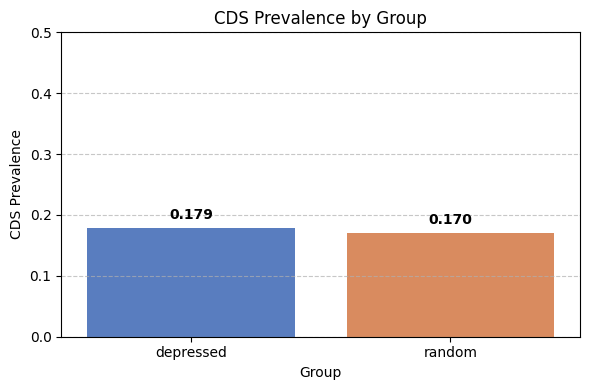

In [45]:
# 📊 1. CDS Prevalence Bar Plot with Values
group_prevalence = df_all.groupby("group")["CDS_detected_flag"].mean().reset_index()
group_prevalence.columns = ["Group", "CDS Prevalence"]

plt.figure(figsize=(6, 4))
bar = sns.barplot(data=group_prevalence, x="Group", y="CDS Prevalence", palette="muted")
for i, val in enumerate(group_prevalence["CDS Prevalence"]):
    bar.text(i, val + 0.01, f"{val:.3f}", ha='center', va='bottom', fontweight='bold')
plt.title("CDS Prevalence by Group")
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

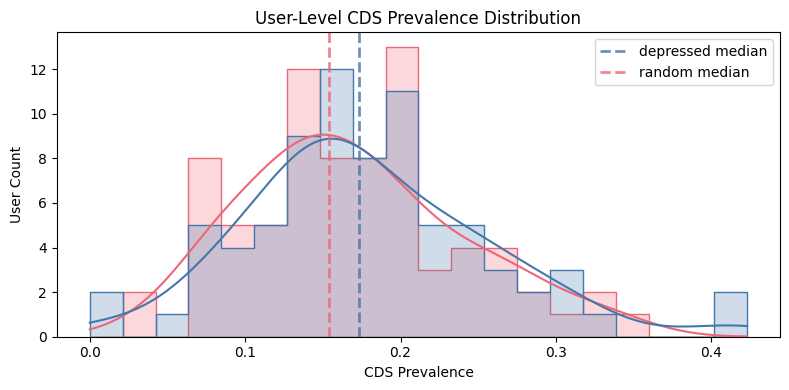

In [53]:
plt.figure(figsize=(8, 4))
palette = {"depressed": "#4477AA", "random": "#EE6677"}  # Example color codes

sns.histplot(
    data=user_stats,
    x="CDS_prevalence",
    hue="group",
    bins=20,
    kde=True,
    element="step",
    palette=palette
)

for group, color in palette.items():
    med = user_stats[user_stats.group == group]["CDS_prevalence"].median()
    plt.axvline(
        med,
        linestyle="--",
        label=f"{group} median",
        alpha=0.8,
        color=color,
        linewidth=2
    )

plt.title("User-Level CDS Prevalence Distribution")
plt.xlabel("CDS Prevalence")
plt.ylabel("User Count")
plt.legend()
plt.tight_layout()
plt.show()


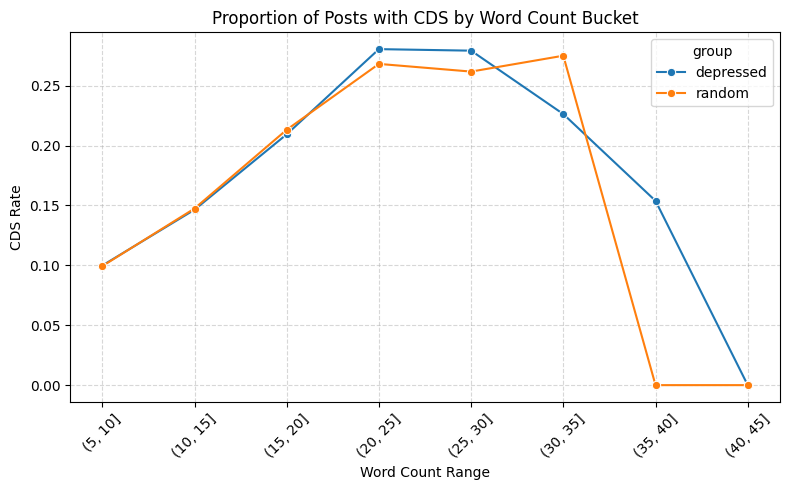

In [60]:
# Bin word counts into ranges
df_all["word_bin"] = pd.cut(df_all["word_count"], bins=range(5, 50, 5))

# Compute CDS rate per bin per group
cds_rate = (
    df_all.groupby(["word_bin", "group"], observed=True)["CDS_detected_flag"]
    .mean()
    .reset_index()
)
cds_rate["word_bin"] = cds_rate["word_bin"].astype(str)  # Fix for lineplot

# Plot line graph
plt.figure(figsize=(8, 5))
sns.lineplot(data=cds_rate, x="word_bin", y="CDS_detected_flag", hue="group", marker="o")
plt.title("Proportion of Posts with CDS by Word Count Bucket")
plt.xlabel("Word Count Range")
plt.ylabel("CDS Rate")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


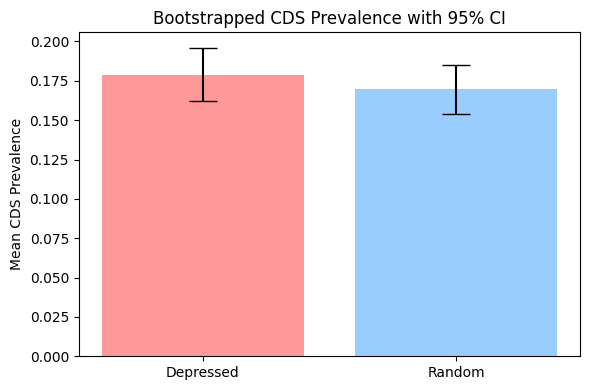

In [51]:
# === 4. Bootstrap Confidence Interval ===
def bootstrap_mean_ci(data, B=10000, alpha=0.05):
    means = np.random.choice(data, size=(B, len(data)), replace=True).mean(axis=1)
    return means.mean(), np.percentile(means, [100 * alpha / 2, 100 * (1 - alpha / 2)])

boot_dep = df_dep.groupby("username")["CDS_detected_flag"].mean()
boot_rand = df_rand.groupby("username")["CDS_detected_flag"].mean()

dep_mean, dep_ci = bootstrap_mean_ci(boot_dep)
rand_mean, rand_ci = bootstrap_mean_ci(boot_rand)

plt.figure(figsize=(6, 4))
plt.bar(["Depressed", "Random"], [dep_mean, rand_mean], yerr=[
    [dep_mean - dep_ci[0], rand_mean - rand_ci[0]],
    [dep_ci[1] - dep_mean, rand_ci[1] - rand_mean]
], capsize=10, color=["#ff9999", "#99ccff"])
plt.title("Bootstrapped CDS Prevalence with 95% CI")
plt.ylabel("Mean CDS Prevalence")
plt.tight_layout()
plt.show()

<ipython-input-57-5fa68d6220ce>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=user_stats, x="group", y="CDS_prevalence", palette="pastel", width=0.5)


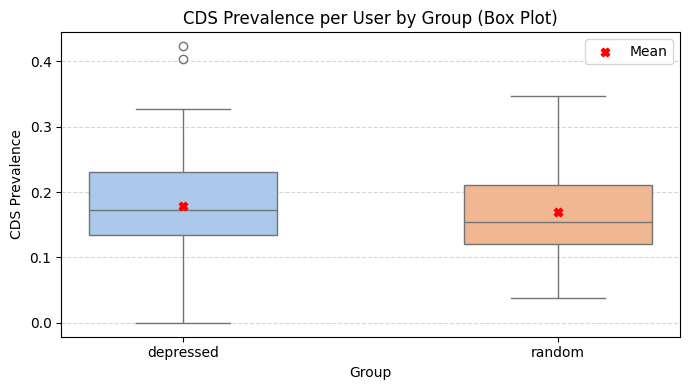

In [57]:
# === Box Plot ===
plt.figure(figsize=(7, 4))
sns.boxplot(data=user_stats, x="group", y="CDS_prevalence", palette="pastel", width=0.5)

# Add red X marker for group means
group_means = user_stats.groupby("group")["CDS_prevalence"].mean()
for i, (group, mean_val) in enumerate(group_means.items()):
    plt.scatter(i, mean_val, color="red", marker='X', zorder=10, label="Mean" if i == 0 else "")

plt.title("CDS Prevalence per User by Group (Box Plot)")
plt.ylabel("CDS Prevalence")
plt.xlabel("Group")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## **Perplexity Visuals**

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load user-level perplexity files ===
df_dep_ppl = pd.read_json("/content/user_dep_perplexity.json", lines=True)
df_rand_ppl = pd.read_json("/content/user_rand_perplexity.json", lines=True)

# === Add group labels ===
df_dep_ppl["group"] = "depressed"
df_rand_ppl["group"] = "random"

# === Combine into one dataframe ===
df_ppl = pd.concat([df_dep_ppl, df_rand_ppl], ignore_index=True)

# === Standardize column names if needed ===
# Make sure column is named 'perplexity' — adjust if it's 'avg_perplexity' or similar
if "avg_perplexity" in df_ppl.columns:
    df_ppl.rename(columns={"avg_perplexity": "perplexity"}, inplace=True)

<ipython-input-63-739679bebe19>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ppl, x="group", y="perplexity", palette="pastel", width=0.5)


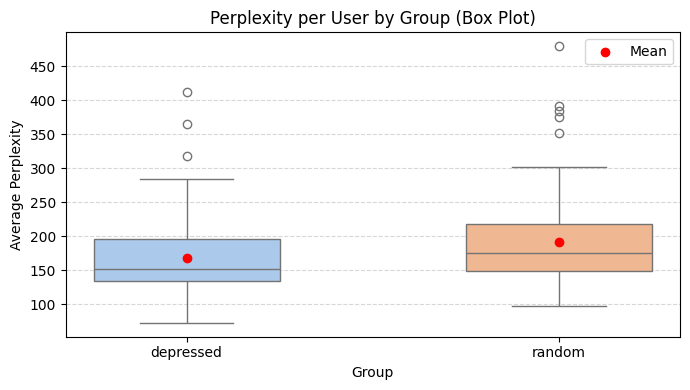

In [63]:
# === Plot 1: Box Plot ===
plt.figure(figsize=(7, 4))
sns.boxplot(data=df_ppl, x="group", y="perplexity", palette="pastel", width=0.5)

# Add group means
group_means = df_ppl.groupby("group")["perplexity"].mean()
for i, (grp, val) in enumerate(group_means.items()):
    plt.scatter(i, val, color="red", label="Mean" if i == 0 else "", zorder=10)

plt.title("Perplexity per User by Group (Box Plot)")
plt.ylabel("Average Perplexity")
plt.xlabel("Group")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


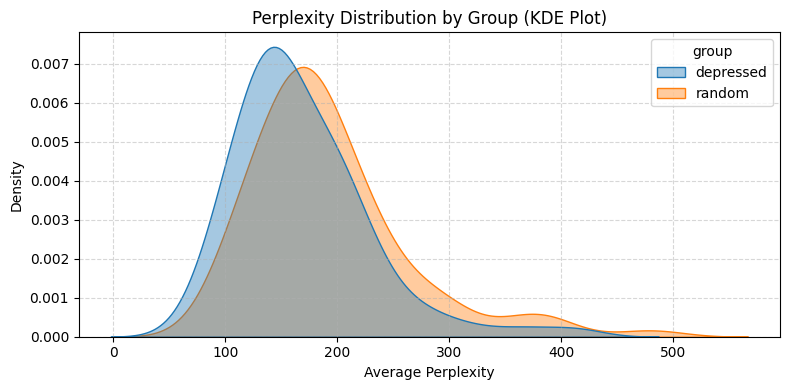

In [64]:
# === Plot 2: KDE (Density) Plot ===
plt.figure(figsize=(8, 4))
sns.kdeplot(data=df_ppl, x="perplexity", hue="group", fill=True, common_norm=False, alpha=0.4)
plt.title("Perplexity Distribution by Group (KDE Plot)")
plt.xlabel("Average Perplexity")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


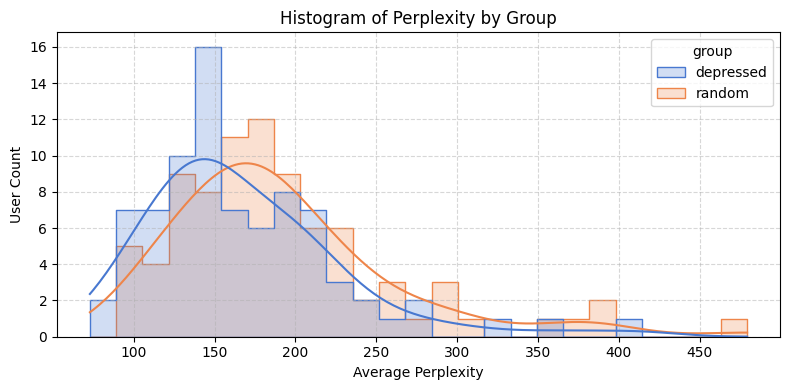

In [65]:
# === Plot 3: Histogram ===
plt.figure(figsize=(8, 4))
sns.histplot(data=df_ppl, x="perplexity", hue="group", bins=25, kde=True, element="step", palette="muted")
plt.title("Histogram of Perplexity by Group")
plt.xlabel("Average Perplexity")
plt.ylabel("User Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

📉 Pearson Correlation (CDS vs Perplexity): -0.159


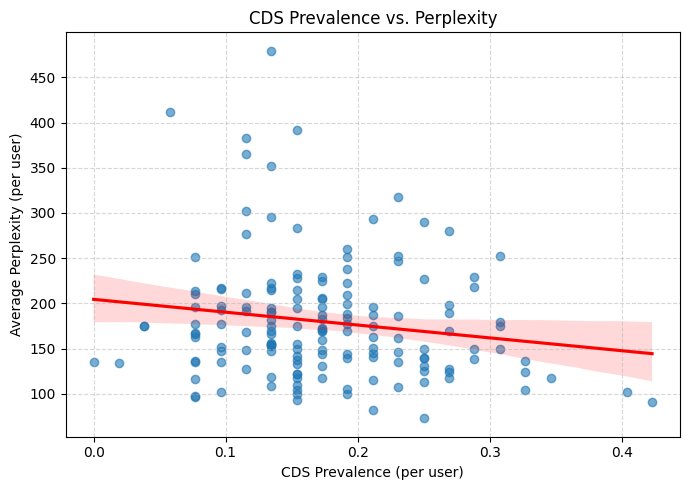


📊 Correlation by Group:
group
depressed   -0.141014
random      -0.161932
Name: (CDS_prevalence, perplexity), dtype: float64


In [66]:
# 📦 Merge user-level perplexity with CDS prevalence
merged = pd.merge(user_stats, df_ppl, on=["username", "group"], how="inner")

# 🧠 Compute Pearson correlation
corr = merged["perplexity"].corr(merged["CDS_prevalence"])
print(f"📉 Pearson Correlation (CDS vs Perplexity): {corr:.3f}")

# 📈 Scatter Plot with Regression Line
plt.figure(figsize=(7, 5))
sns.regplot(data=merged, x="CDS_prevalence", y="perplexity", scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.title("CDS Prevalence vs. Perplexity")
plt.xlabel("CDS Prevalence (per user)")
plt.ylabel("Average Perplexity (per user)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optional: Correlation by group
group_corrs = merged.groupby("group")[["CDS_prevalence", "perplexity"]].corr().unstack().iloc[:, 1]
print("\n📊 Correlation by Group:")
print(group_corrs)
